# Preparations

## Mount the drive where all the data is located at

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to the folder inside which all the data is located
# Relative to the root of the mounted Google Drive
DRIVE_PATH = 'drive/MyDrive/Team_3_PAMiSE'

## Installing necessary dependencies

In [3]:
!pip install pm4py==2.7.8.1 elementpath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26094 sha256=e036bb212a9888e279419fbc9db0b5808463d7e297231df29afe891b3de48464
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16966 sha256=5deea408de62cccce1a829d7e361ce8cfa3403ce0dc852f7ade60e4530483775
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist


## Precalc
To make it compatible with pm4py (timestamps)

In [4]:
import xml.etree.ElementTree as et
import elementpath
from dateutil import parser

### Loading original .xes as an xml to fix timestamp formats

In [5]:
tree = et.parse(f'{DRIVE_PATH}/server_nonconcurrent.xes')

In [6]:
events = tree.getroot().findall('./trace/event')

### Transform the timestamps so that the it is after the beginning of the era

In [7]:
for event in events:
  date = event.find('date')
  original_timestamp = date.get('value')
  result_timestamp = parser.parse(original_timestamp)
  result_timestamp = result_timestamp.replace(year=result_timestamp.year + 1970)
  result_timestamp_str = str(result_timestamp.isoformat())
  date.set('value', result_timestamp_str)

# Saving fixed .xes
tree.write(f'{DRIVE_PATH}/server_nonconcurrent_clean.xes')

In [8]:
del tree
del events

# Loading

In [9]:
import pm4py
import re
import numpy as np
import pandas as pd

In [10]:
log = pm4py.read_xes(f'{DRIVE_PATH}/server_nonconcurrent_clean.xes')

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

# Analysis

In [11]:
log.head()

,time:timestamp,concept:name,Event_ID,ManagedThreadId,case:concept:name,lifecycle:transition,concept:instance
0,1971-01-06 17:54:15.412502+00:00,Procfiler/MethodStart_{LOHALLOCATIONS.PROGRAM....,8,16228,0,NaN,NaN
1,1971-01-06 17:54:15.412579+00:00,GC/SampledObjectAllocation_{System.Collections...,9,16228,0,NaN,NaN
2,1971-01-06 17:54:15.412580+00:00,Procfiler/MethodStart_{SYSTEM.COLLECTIONS.GENE...,10,16228,0,NaN,NaN
3,1971-01-06 17:54:15.412581+00:00,Procfiler/MethodStart_{SYSTEM.OBJECT..CTOR[INS...,11,16228,0,NaN,NaN
4,1971-01-06 17:54:15.412582+00:00,Procfiler/MethodEnd_{SYSTEM.OBJECT..CTOR[INSTA...,12,16228,0,NaN,NaN


Every `Event_ID` as well as `case:concept:name` is numeric

In [12]:
event_ids = log['Event_ID'].unique()
for event_id in event_ids:
  assert event_id.isnumeric()

In [13]:
case_concept_names = log['case:concept:name'].unique()
for case_concept_name in case_concept_names:
  assert case_concept_name.isnumeric()

In [14]:
log['Event_ID'] = log['Event_ID'].astype(int)

There are 4 categories: Procfiler, GC, Method, AssemblyLoader, Loader

In [15]:
# Extract categories
categories = log['concept:name'].apply(lambda x: x.split('/')[0]).unique()

There are subcategories for all the categories as well

In [16]:
def extract_subcategory(name):
  return name.split('/', maxsplit=1)[1].split('_')[0]

for category in categories:
  entries = log[log['concept:name'].str.startswith(category + '/')]
  subcategories = entries['concept:name'].apply(extract_subcategory).unique()
  print(f"Category '{category}': {subcategories}")
  print()

Category 'Procfiler': ['MethodStart' 'MethodEnd']

Category 'GC': ['SampledObjectAllocation' 'Triggered' 'SuspendEEStart' 'SuspendEEStop'
 'Start' 'PinObjectAtGCTime' 'Stop' 'RestartEEStart' 'RestartEEStop'
 'FinalizersStart' 'FinalizersStop' 'SetGCHandle']

Category 'Method': ['MemoryAllocatedForJitCode' 'LoadVerbose' 'InliningSucceeded'
 'InliningFailed']

Category 'AssemblyLoader': ['Start' 'KnownPathProbed'
 'ResolutionAttemptedFindInLoadContextAssemblyNotFound'
 'ResolutionAttemptedApplicationAssembliesSuccess' 'Stop']

Category 'Loader': ['AssemblyLoad' 'ModuleLoad' 'DomainModuleLoad']



## Observations

The main method invocation is the first entry and there is no other entries prior (in terms of Event_ID)

In [17]:
first_entry = log.iloc[0]
assert len(log[log['Event_ID'] < first_entry['Event_ID']]) == 0
first_entry['concept:name']

'Procfiler/MethodStart_{LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.SYSTEM.STRING[])]}'

`case:concept:name` indicates the amount of times the program was executed (the main method was invoked).

To prove it, we'll check the following hypotheses:

1.   Main method was started the number of times equal to the unique `case:concept:name` values
2.   Main method was ended the same amount of times
3.   There are no entries between main method start and main method end with `case:concept:name` different from the corresponding value for the main method

Moreover, we can collect data for these invocations (which we'll from now on call 'launches' -- there are 25 of them)

In [18]:
main_start_name = "Procfiler/MethodStart_{LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.SYSTEM.STRING[])]}"
main_end_name = "Procfiler/MethodEnd_{LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.SYSTEM.STRING[])]}"

In [19]:
case_concept_names = log['case:concept:name'].astype(int)
start_indexes = log[log['concept:name'] == main_start_name].index
end_indexes = log[log['concept:name'] == main_end_name].index

assert len(case_concept_names.unique()) == len(start_indexes) == len(end_indexes)
assert start_indexes.is_monotonic_increasing
assert end_indexes.is_monotonic_increasing
assert case_concept_names.is_monotonic_increasing

launches = []

for i in range(len(start_indexes)):
  assert start_indexes[i] < end_indexes[i]
  start_entry = log.loc[start_indexes[i]]
  end_entry = log.loc[end_indexes[i]]
  between = log.loc[start_indexes[i] : end_indexes[i]]
  unqiue_cases = between['case:concept:name'].unique()
  assert len(unqiue_cases) == 1
  assert unqiue_cases[0] == start_entry['case:concept:name'] == end_entry['case:concept:name']

  launches.append(between.copy(deep=True))

print(len(launches))

25


There are exactly two managed threads per each launch: System (C# Runtime) and the main one inside which the program flow is executed (and some allocations are made).

This concludes that the examined (profiled) program is single-threaded.

In [20]:
thread_ids = []
for index, launch in enumerate(launches):
  managed_thread_ids = launch['ManagedThreadId']
  print(f'Launch [#{index}]', 'Unique threads', managed_thread_ids.unique())
  assert len(managed_thread_ids.unique()) == 2
  assert '-1' in managed_thread_ids.unique()
  system = launch[managed_thread_ids == '-1']
  assert len(system[system['concept:name'].str.startswith('Procfiler/')]) == 0
  thread_ids += [launch[managed_thread_ids != '-1']['ManagedThreadId'].to_numpy()[0]]

Launch [#0] Unique threads ['16228' '-1']
Launch [#1] Unique threads ['16380' '-1']
Launch [#2] Unique threads ['12244' '-1']
Launch [#3] Unique threads ['2132' '-1']
Launch [#4] Unique threads ['16676' '-1']
Launch [#5] Unique threads ['12664' '-1']
Launch [#6] Unique threads ['16736' '-1']
Launch [#7] Unique threads ['5104' '-1']
Launch [#8] Unique threads ['17056' '-1']
Launch [#9] Unique threads ['6728' '-1']
Launch [#10] Unique threads ['15540' '-1']
Launch [#11] Unique threads ['16432' '-1']
Launch [#12] Unique threads ['14196' '-1']
Launch [#13] Unique threads ['2356' '-1']
Launch [#14] Unique threads ['14972' '-1']
Launch [#15] Unique threads ['13912' '-1']
Launch [#16] Unique threads ['5100' '-1']
Launch [#17] Unique threads ['7700' '-1']
Launch [#18] Unique threads ['7076' '-1']
Launch [#19] Unique threads ['4232' '-1']
Launch [#20] Unique threads ['9540' '-1']
Launch [#21] Unique threads ['16244' '-1']
Launch [#22] Unique threads ['5100' '-1']
Launch [#23] Unique threads ['1

Notice that there are non-unique non-system threads

In [21]:
pd.Series(thread_ids).value_counts().loc[lambda x: x > 1]

5100    2
dtype: int64

We can see that there's a single allocation of list of bytes per launch, straight after the main method end

In [22]:
# The list of array of bytes has been allocated 25 times -- once per program (Main method) invocation
allocation_name = 'GC/SampledObjectAllocation_{System.Collections.Generic.List`1[System.Byte[]]}'

In [23]:
log[log['concept:name'] == allocation_name][['concept:name', 'case:concept:name']]

,concept:name,case:concept:name
1,GC/SampledObjectAllocation_{System.Collections...,0
53512,GC/SampledObjectAllocation_{System.Collections...,1
106995,GC/SampledObjectAllocation_{System.Collections...,2
160358,GC/SampledObjectAllocation_{System.Collections...,3
213713,GC/SampledObjectAllocation_{System.Collections...,4
267266,GC/SampledObjectAllocation_{System.Collections...,5
320381,GC/SampledObjectAllocation_{System.Collections...,6
373896,GC/SampledObjectAllocation_{System.Collections...,7
427333,GC/SampledObjectAllocation_{System.Collections...,8
480802,GC/SampledObjectAllocation_{System.Collections...,9


In [24]:
filtered = pm4py.filter_between(log, main_start_name, allocation_name)
following = filtered[(filtered['concept:name'] == allocation_name).shift(-1).fillna(False)]
len(following['concept:name'].unique()), following['concept:name'].unique()[0]

(1,
 'Procfiler/MethodStart_{LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.SYSTEM.STRING[])]}')

List of all the methods invoked

In [25]:
method_start_prefix = 'Procfiler/MethodStart_'
method_end_prefix = 'Procfiler/MethodEnd_'

In [26]:
def extract_method(name: str):
  after_category = name.split('/', maxsplit=1)[1]
  after_subcategory = after_category.split('_', maxsplit=1)[1]
  # Notice curly braces around method name: {method_name}
  return after_subcategory[1:-1]

method_log = log[log['concept:name'].str.startswith(method_start_prefix)]
sorted(method_log['concept:name'].apply(extract_method).unique())

['INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ADDBYTEOFFSET[GENERIC.!!0&..(!!0&,INT)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ADDBYTEOFFSET[GENERIC.!!0&..(!!0&,UNSIGNED.INT)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ADD[GENERIC.!!0&..(!!0&,INT)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ADD[GENERIC.!!0&..(!!0&,INT32)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ASREF[GENERIC.!!0&..(VOID*)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.AS[GENERIC.!!0..(CLASS.SYSTEM.OBJECT)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.AS[GENERIC.!!1&..(!!0&)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.ISNULLREF[GENERIC.BOOL..(!!0&)]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.NULLREF[GENERIC.!!0&..()]',
 'INTERNAL.RUNTIME.COMPILERSERVICES.UNSAFE.SIZEOF[GENERIC.INT32..()]',
 'INTEROP.GETRANDOMBYTES[VOID..(UNSIGNED.INT8*,INT32)]',
 'LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.SYSTEM.STRING[])]',
 'SYSTEM.APPCONTEXT.GETDATA[CLASS.SYSTEM.OBJECT..(CLASS.SYSTEM.STRING)]',
 'SYSTEM.APPCONTEXT.TRYGETSW

## DFG

By categories

In [27]:
shrinked_log = log.copy(deep=True)
shrinked_log['concept:name'] = shrinked_log['concept:name'].apply(lambda name: name.split('_', maxsplit=1)[0])

In [28]:
shrinked_log.head()

,time:timestamp,concept:name,Event_ID,ManagedThreadId,case:concept:name,lifecycle:transition,concept:instance
0,1971-01-06 17:54:15.412502+00:00,Procfiler/MethodStart,8,16228,0,NaN,NaN
1,1971-01-06 17:54:15.412579+00:00,GC/SampledObjectAllocation,9,16228,0,NaN,NaN
2,1971-01-06 17:54:15.412580+00:00,Procfiler/MethodStart,10,16228,0,NaN,NaN
3,1971-01-06 17:54:15.412581+00:00,Procfiler/MethodStart,11,16228,0,NaN,NaN
4,1971-01-06 17:54:15.412582+00:00,Procfiler/MethodEnd,12,16228,0,NaN,NaN


Overall DFG for categories

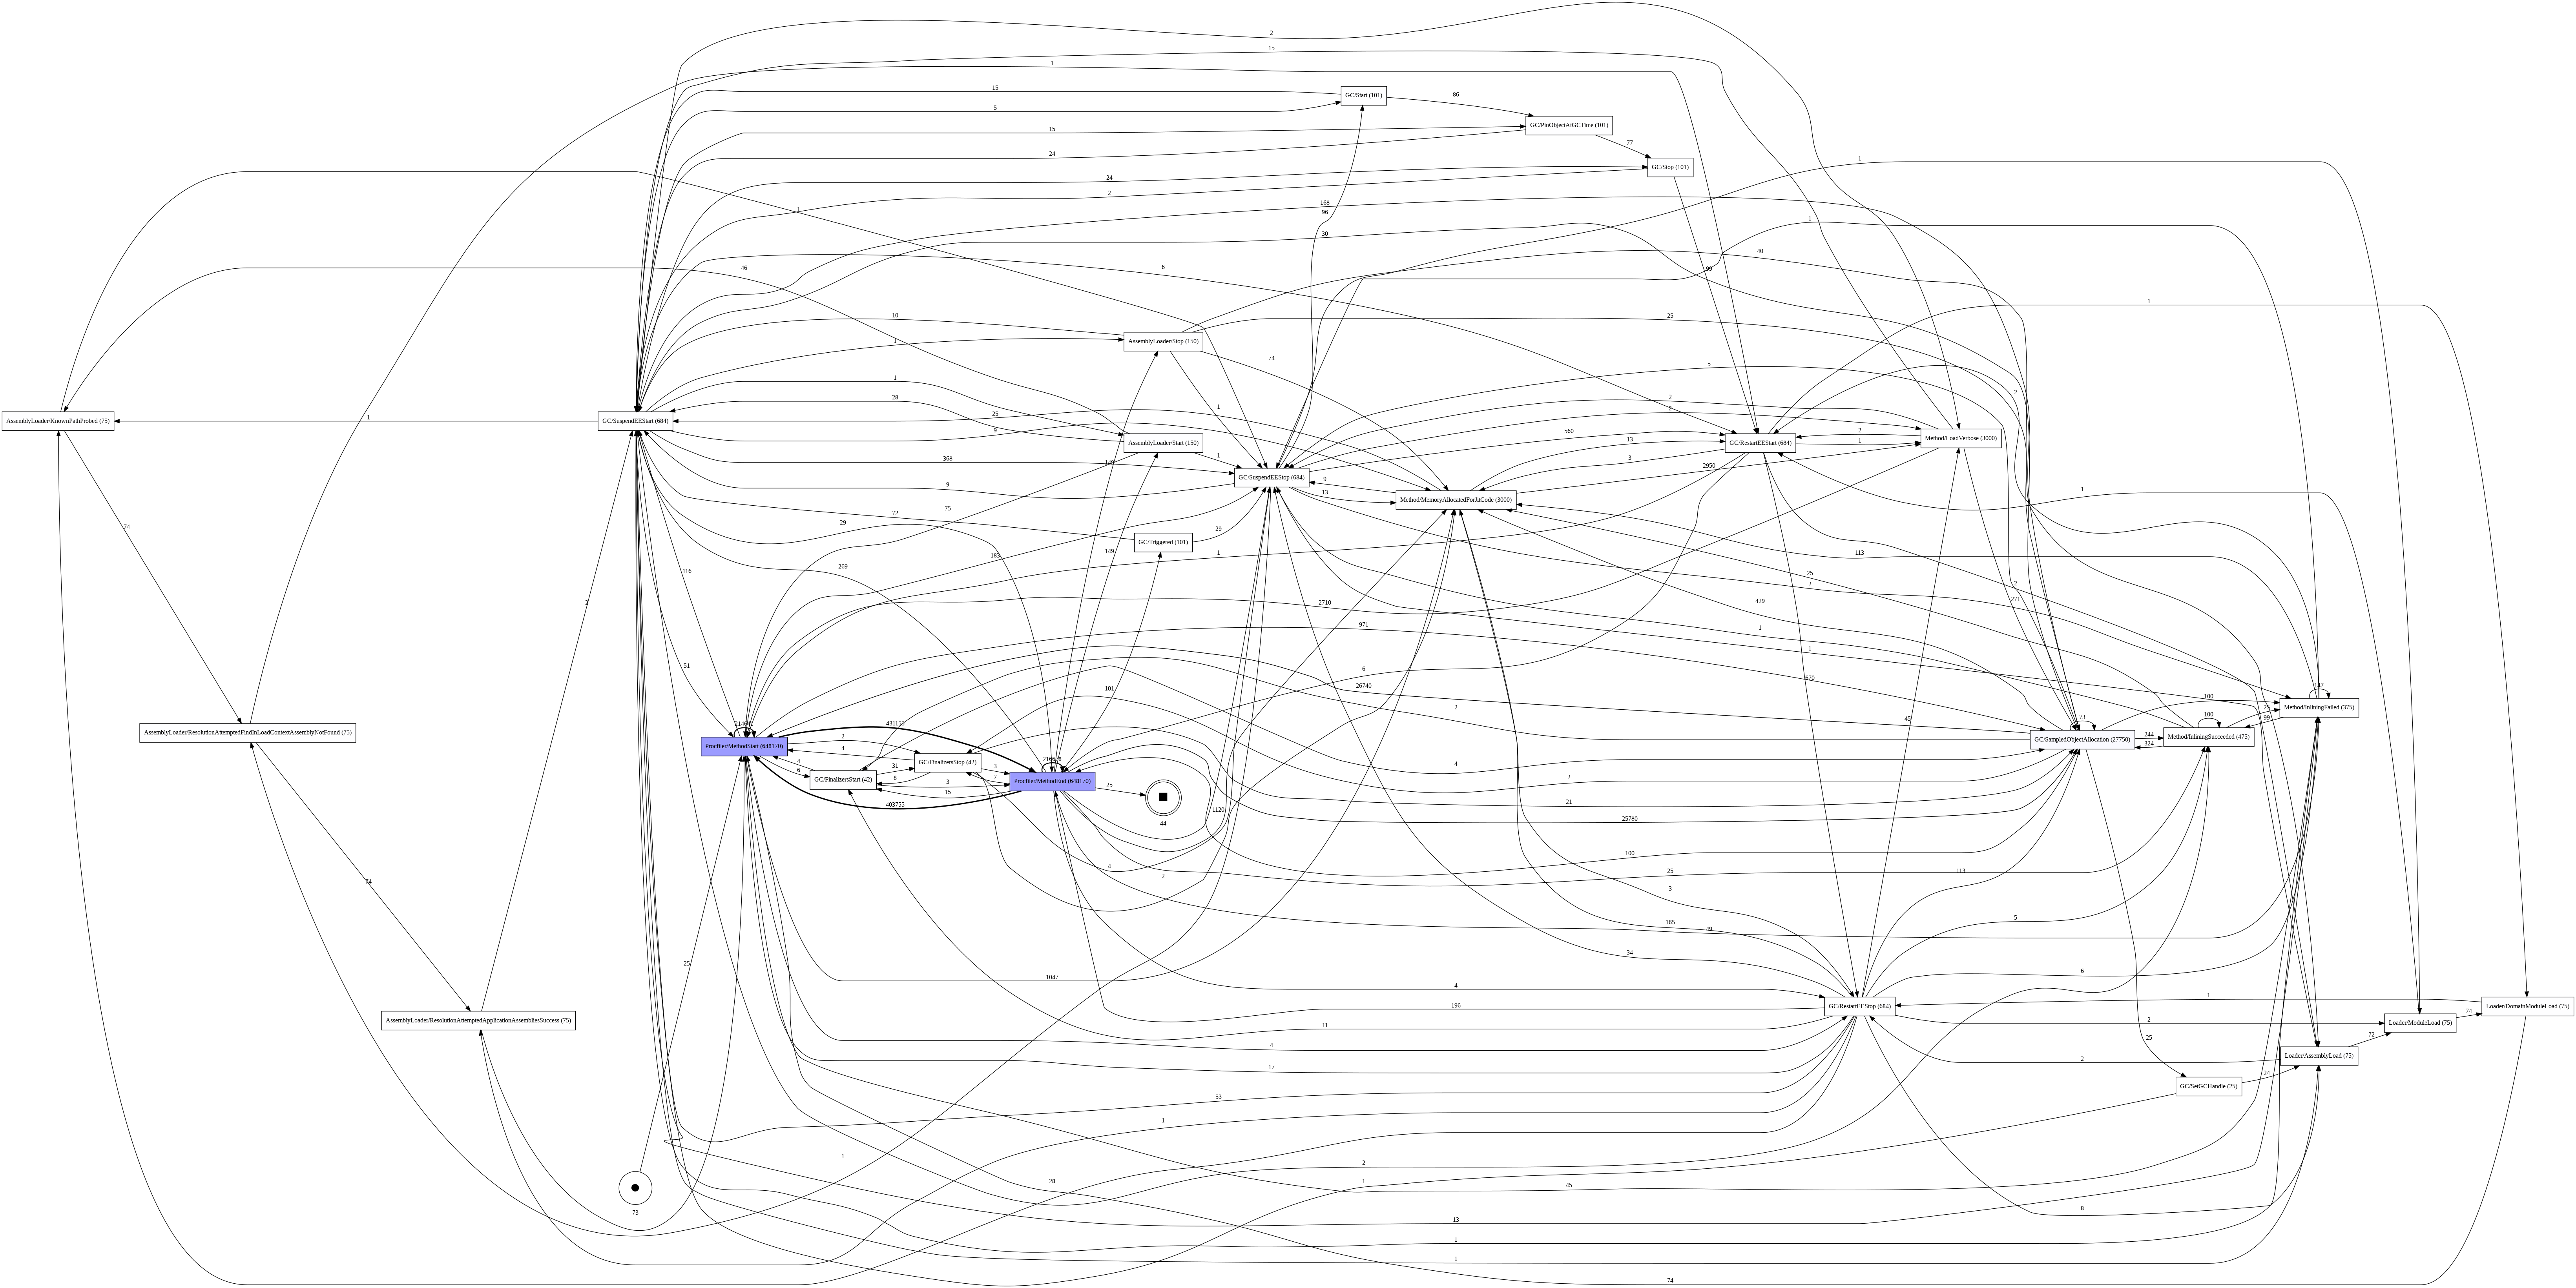

In [29]:
pm4py.view_dfg(*pm4py.discover_directly_follows_graph(shrinked_log))

In [30]:
del shrinked_log

### DFG for Methods (first launch)

In [31]:
first_launch = launches[0]
shorten_copy = first_launch[first_launch['concept:name'].str.startswith(method_start_prefix) | first_launch['concept:name'].str.startswith(method_end_prefix)]

def shorten_name(name):
  method_start = 'Procfiler/MethodStart' in name
  method_name = name.split('_', maxsplit=1)[1][1:-1]
  result = ''
  for part in method_name.split('.'):
    if part == 'SYSTEM':
      result += 'S.'
    else:
      result += part + '.'
  if method_start:
    return result
  else:
    return '*' + result

shorten_copy['concept:name'] = shorten_copy['concept:name'].apply(shorten_name)
shorten_copy

<ipython-input-31-86bdfd3891c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorten_copy['concept:name'] = shorten_copy['concept:name'].apply(shorten_name)


,time:timestamp,concept:name,Event_ID,ManagedThreadId,case:concept:name,lifecycle:transition,concept:instance
0,1971-01-06 17:54:15.412502+00:00,LOHALLOCATIONS.PROGRAM.MAIN[VOID..(CLASS.S.STR...,8,16228,0,NaN,NaN
2,1971-01-06 17:54:15.412580+00:00,S.COLLECTIONS.GENERIC.LIST`1[SYSTEM.__CANON].....,10,16228,0,NaN,NaN
3,1971-01-06 17:54:15.412581+00:00,S.OBJECT..CTOR[INSTANCE.VOID..()].,11,16228,0,NaN,NaN
4,1971-01-06 17:54:15.412582+00:00,*S.OBJECT..CTOR[INSTANCE.VOID..()].,12,16228,0,NaN,NaN
5,1971-01-06 17:54:15.412591+00:00,S.COLLECTIONS.GENERIC.LIST`1[SYSTEM.__CANON].....,13,16228,0,NaN,NaN
...,...,...,...,...,...,...,...
53506,1971-01-06 17:54:15.484657+00:00,*S.IO.TEXTWRITER.WRITELINE[INSTANCE.VOID..()].,53514,16228,0,NaN,NaN
53507,1971-01-06 17:54:15.484657+00:00,*S.IO.TEXTWRITER.WRITELINE[INSTANCE.VOID..(INT...,53515,16228,0,NaN,NaN
53508,1971-01-06 17:54:15.484658+00:00,*S.IO.TEXTWRITER+SYNCTEXTWRITER.WRITELINE[INST...,53516,16228,0,NaN,NaN
53509,1971-01-06 17:54:15.484658+00:00,*S.CONSOLE.WRITELINE[VOID..(INT32)].,53517,16228,0,NaN,NaN


In [32]:
from pm4py.visualization.dfg import visualizer as dfg_visualization
dfg = pm4py.discover_directly_follows_graph(shorten_copy)[0]
gviz = dfg_visualization.apply(dfg, log=shorten_copy, parameters={'format': 'svg'})
dfg_visualization.save(gviz, 'methods_per_launch.svg')
None

/usr/local/lib/python3.10/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


Notice, that after `Console.WriteLine(...)` invocation our program stops.  
This is concluded from the method DFG. Same conclusions can be made from DFG containing flow after `Console.WriteLine(...)`

In [33]:
console_write_name = "Procfiler/MethodStart_{SYSTEM.CONSOLE.WRITELINE[VOID..(INT32)]}"

In [34]:
from pm4py.visualization.dfg import visualizer as dfg_visualization

raw_methods_log = first_launch[first_launch['concept:name'].str.startswith(method_start_prefix) | first_launch['concept:name'].str.startswith(method_end_prefix)]
methods_per_launch_after = pm4py.filter_between(raw_methods_log, console_write_name, main_end_name)

dfg = pm4py.discover_directly_follows_graph(methods_per_launch_after)[0]
gviz = dfg_visualization.apply(dfg, log=methods_per_launch_after, parameters={'format': 'svg'})
dfg_visualization.save(gviz, 'after_console_writeline.svg')
None

# SANDBOX

In [ ]:
pm4py.discovery.discover_log_skeleton(log)

In [ ]:
log['lifecycle:transition'].unique()

array([nan, 'start', 'complete'], dtype=object)

In [ ]:
log[~log['lifecycle:transition'].isna()]["concept:name"].unique()

array(['GC/SuspendEEStart_{GC}', 'GC/SuspendEEStop',
       'GC/Start_{ALLOC_LARGENC_GC}', 'GC/SuspendEEStart_{OTHER}',
       'GC/Stop', 'GC/RestartEEStart', 'GC/RestartEEStop',
       'GC/FinalizersStart', 'GC/FinalizersStop',
       'Method/LoadVerbose_{System.Randomget_Shared}',
       'Method/LoadVerbose_{System.Random.cctor}',
       'Method/LoadVerbose_{System.Random+ThreadSafeRandom.ctor}',
       'Method/LoadVerbose_{System.Random.ctor}',
       'Method/LoadVerbose_{System.Collections.Generic.List`1[System.__Canon]get_Count}',
       'Method/LoadVerbose_{System.Random+ThreadSafeRandomNext}',
       'Method/LoadVerbose_{System.Random+ThreadSafeRandomget_LocalRandom}',
       'Method/LoadVerbose_{System.Random+ThreadSafeRandomCreate}',
       'Method/LoadVerbose_{System.Random+XoshiroImpl.ctor}',
       'Method/LoadVerbose_{InteropGetRandomBytes}',
       'Method/LoadVerbose_{System.Random+XoshiroImplNext}',
       'Method/LoadVerbose_{System.Collections.Generic.List`1[System.__

In [ ]:
for event in log['concept:instance'].unique():
  print(event)

In [ ]:
log[log['concept:name'].str.contains("GC/Start_")]

,time:timestamp,concept:name,Event_ID,ManagedThreadId,case:concept:name,lifecycle:transition,concept:instance
771,1971-01-06 17:54:15.413715+00:00,GC/Start_{ALLOC_LARGENC_GC},779,-1,0,start,GC_1
19243,1971-01-06 17:54:15.424301+00:00,GC/Start_{ALLOC_LARGENC_GC},19251,-1,0,start,GC_2
31573,1971-01-06 17:54:15.437062+00:00,GC/Start_{ALLOC_LARGENC_GC},31581,-1,0,start,GC_3
43687,1971-01-06 17:54:15.446711+00:00,GC/Start_{ALLOC_LARGENC_GC},43695,-1,0,start,GC_4
54281,1971-01-06 17:54:33.768847+00:00,GC/Start_{ALLOC_LARGENC_GC},54297,-1,1,start,GC_1
...,...,...,...,...,...,...,...
1282326,1971-01-06 18:01:21.751986+00:00,GC/Start_{ALLOC_LARGENC_GC},1282526,-1,24,start,GC_1
1294868,1971-01-06 18:01:21.760531+00:00,GC/Start_{ALLOC_LARGENC_GC},1295068,-1,24,start,GC_2
1307136,1971-01-06 18:01:21.775749+00:00,GC/Start_{ALLOC_LARGENC_GC},1307336,-1,24,start,GC_3
1324881,1971-01-06 18:01:21.784960+00:00,GC/Start_{ALLOC_LARGENC_GC},1325081,-1,24,start,GC_4


In [ ]:
launches[0][launches[0]["concept:name"].str.contains("\.ADD")]

,time:timestamp,concept:name,Event_ID,ManagedThreadId,case:concept:name,lifecycle:transition,concept:instance
10,1971-01-06 17:54:15.412648+00:00,Procfiler/MethodStart_{SYSTEM.COLLECTIONS.GENE...,18,16228,0,NaN,NaN
11,1971-01-06 17:54:15.412648+00:00,Procfiler/MethodStart_{SYSTEM.COLLECTIONS.GENE...,19,16228,0,NaN,NaN
21,1971-01-06 17:54:15.412654+00:00,Procfiler/MethodEnd_{SYSTEM.COLLECTIONS.GENERI...,29,16228,0,NaN,NaN
22,1971-01-06 17:54:15.412654+00:00,Procfiler/MethodEnd_{SYSTEM.COLLECTIONS.GENERI...,30,16228,0,NaN,NaN
24,1971-01-06 17:54:15.412660+00:00,Procfiler/MethodStart_{SYSTEM.COLLECTIONS.GENE...,32,16228,0,NaN,NaN
...,...,...,...,...,...,...,...
53312,1971-01-06 17:54:15.483722+00:00,Procfiler/MethodEnd_{INTERNAL.RUNTIME.COMPILER...,53320,16228,0,NaN,NaN
53446,1971-01-06 17:54:15.484638+00:00,Procfiler/MethodStart_{INTERNAL.RUNTIME.COMPIL...,53454,16228,0,NaN,NaN
53447,1971-01-06 17:54:15.484639+00:00,Procfiler/MethodEnd_{INTERNAL.RUNTIME.COMPILER...,53455,16228,0,NaN,NaN
53474,1971-01-06 17:54:15.484646+00:00,Procfiler/MethodStart_{INTERNAL.RUNTIME.COMPIL...,53482,16228,0,NaN,NaN
